In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import cv2
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

2024-05-30 20:12:20.540046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 20:12:20.540154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 20:12:20.701497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import pandas as pd

Benign_dir = [ r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/Benign']

Malignant_Pre_B_dirs = [
    r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pre-B'
]

Malignant_Pro_B_dirs = [
    r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pro-B'
]

Malignant_early_Pre_B_dirs = [
    r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] early Pre-B'
]

filepaths = []
labels = []
dict_lists = [Benign_dir, Malignant_Pre_B_dirs,Malignant_Pro_B_dirs, Malignant_early_Pre_B_dirs]
class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
bloodCell_data = pd.concat([Fseries, Lseries], axis=1)
bloodCell_df = pd.DataFrame(bloodCell_data)
print(bloodCell_df.head())
print(bloodCell_df["labels"].value_counts())

                                           filepaths  labels
0  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
1  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
2  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
3  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
4  /kaggle/input/blood-cell-cancer-all-4class/Blo...  Benign
labels
Malignant_early Pre-B    979
Malignant_Pre-B          955
Malignant_Pro-B          796
Benign                   512
Name: count, dtype: int64


In [4]:
bloodCell_df.shape

(3242, 2)

In [5]:
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)

(1815, 2)
(973, 2)
(454, 2)


In [7]:
def remove_noise(image):
    image = image.astype(np.uint8)
    denoised_image = cv2.GaussianBlur(image, (5, 5), 0)
    return denoised_image

image_gen = ImageDataGenerator(preprocessing_function=lambda img: tf.keras.applications.mobilenet_v2.preprocess_input(remove_noise(img)))

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=8,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle=False
                                   )


train_save_path = 'train'
test_save_path = 'test'
val_save_path = 'val'

os.makedirs(train_save_path, exist_ok=True)
os.makedirs(test_save_path, exist_ok=True)
os.makedirs(val_save_path, exist_ok=True)

def save_images_from_generator(generator, save_path):
    total_batches = len(generator)
    for batch_num in range(total_batches):
        imgs, labels = generator.next()
        for i in range(imgs.shape[0]):
            img = tf.keras.preprocessing.image.array_to_img(imgs[i])
            label = generator.labels[generator.index_array[batch_num * generator.batch_size + i]]
            label_folder = os.path.join(save_path, str(label))
            os.makedirs(label_folder, exist_ok=True)
            img.save(os.path.join(label_folder, f"img_{batch_num * generator.batch_size + i}.png"))

# حفظ الصور من التدفقات المختلفة
save_images_from_generator(train, train_save_path)
save_images_from_generator(test, test_save_path)
save_images_from_generator(val, val_save_path)

print("images are saved")

Found 1815 validated image filenames belonging to 4 classes.
Found 973 validated image filenames belonging to 4 classes.
Found 454 validated image filenames belonging to 4 classes.
images are saved


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


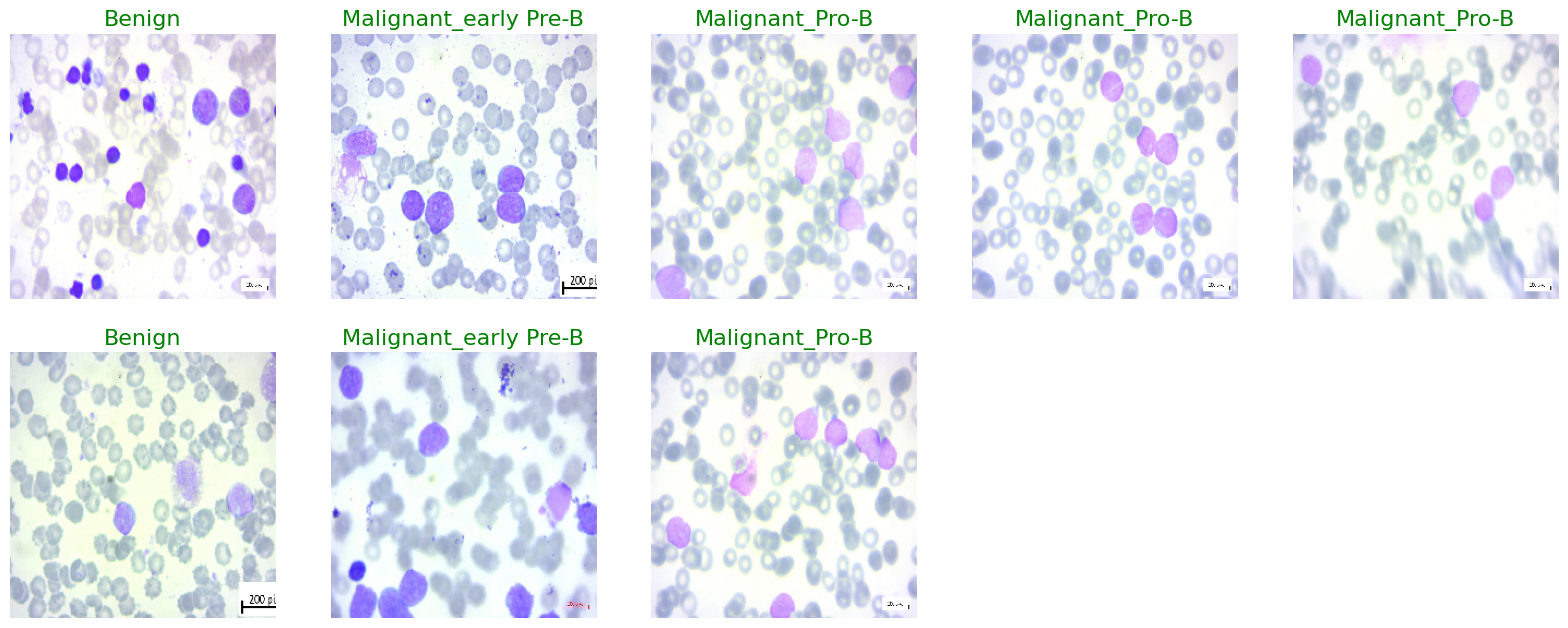

In [9]:
def show_Blood_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_Blood_images(train)

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 73, 73, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                        

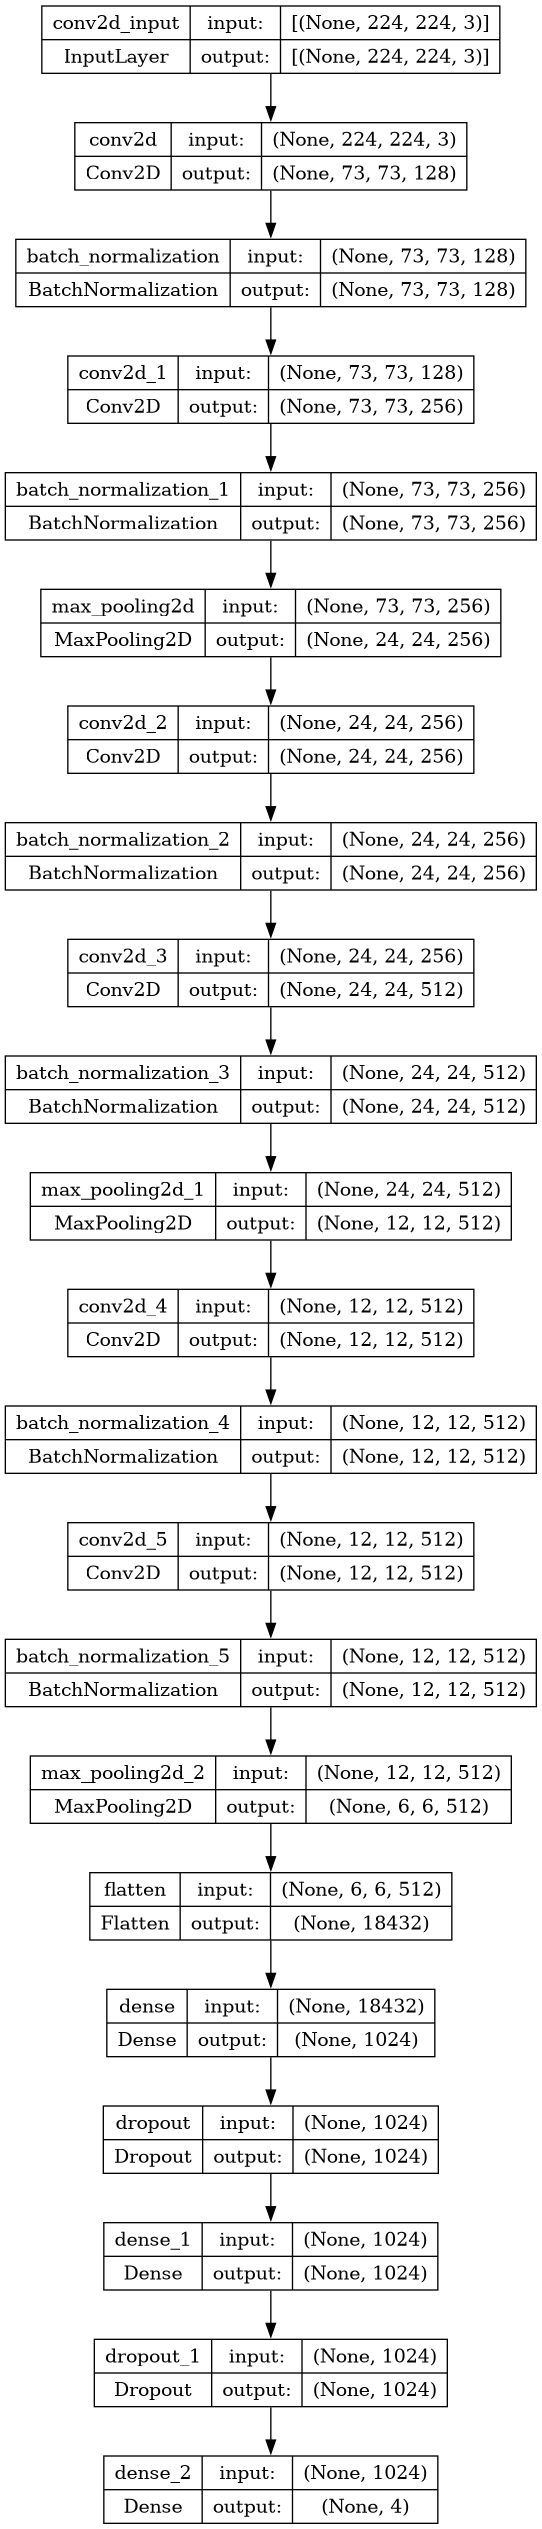

In [11]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
history = model.fit(train, epochs=30, validation_data=val, verbose=1)

Epoch 1/30


I0000 00:00:1717100208.667362     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - 44s 151ms/step - loss: 1.4650 - accuracy: 0.5967 - val_loss: 1.3478 - val_accuracy: 0.3678
Epoch 2/30
227/227 [==============================] - 30s 131ms/step - loss: 0.7165 - accuracy: 0.7609 - val_loss: 0.5356 - val_accuracy: 0.8282
Epoch 3/30
227/227 [==============================] - 29s 128ms/step - loss: 0.4115 - accuracy: 0.8507 - val_loss: 0.4702 - val_accuracy: 0.8172
Epoch 4/30
227/227 [==============================] - 29s 127ms/step - loss: 0.2558 - accuracy: 0.9074 - val_loss: 0.1959 - val_accuracy: 0.9273
Epoch 5/30
227/227 [==============================] - 29s 128ms/step - loss: 0.2088 - accuracy: 0.9245 - val_loss: 0.7189 - val_accuracy: 0.8370
Epoch 6/30
227/227 [==============================] - 29s 126ms/step - loss: 0.1495 - accuracy: 0.9444 - val_loss: 0.1416 - val_accuracy: 0.9581
Epoch 7/30
227/227 [==============================] - 28s 124ms/step - loss: 0.1225 - accuracy: 0.9576 - val_loss: 0.3273 - val_accuracy: 0.8

In [13]:
model.evaluate(test, verbose=1)

122/122 [==============================] - 14s 115ms/step - loss: 0.1222 - accuracy: 0.9774


[0.12216490507125854, 0.9773895144462585]

In [14]:
model.save("leukemia_classification.h5")

In [15]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

122/122 [==============================] - 13s 102ms/step


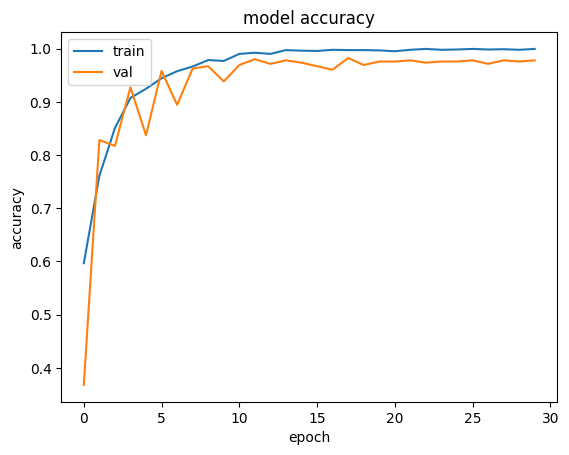

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

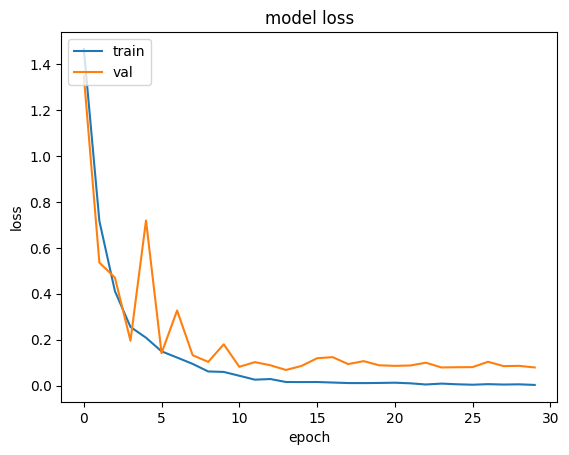

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                       precision    recall  f1-score   support

               Benign       0.95      0.97      0.96       173
      Malignant_Pre-B       0.99      0.98      0.98       286
      Malignant_Pro-B       0.98      1.00      0.99       223
Malignant_early Pre-B       0.98      0.97      0.98       291

             accuracy                           0.98       973
            macro avg       0.97      0.98      0.98       973
         weighted avg       0.98      0.98      0.98       973

Accuracy of the Model: 97.7%


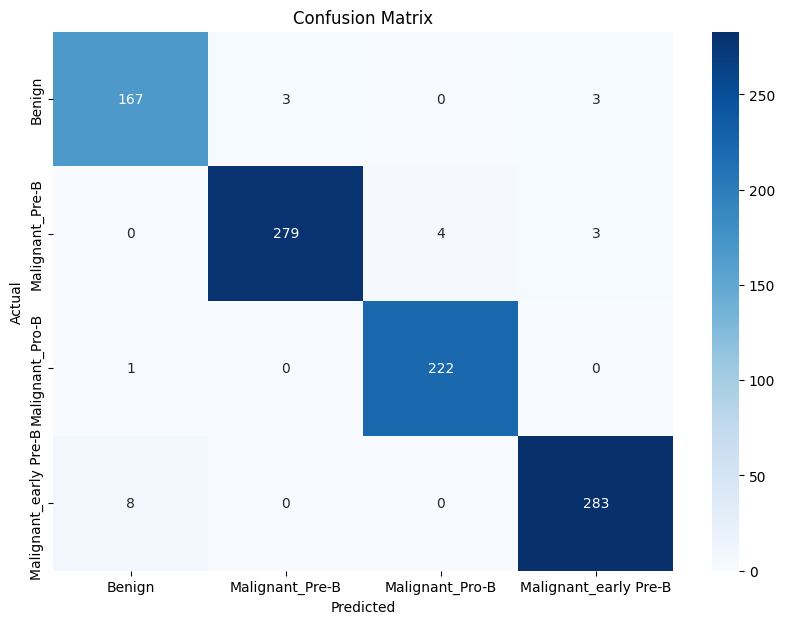

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Benign', 'Malignant_Pre-B', 'Malignant_Pro-B', 'Malignant_early Pre-B']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [20]:
import shutil
from IPython.display import FileLink

shutil.make_archive('/kaggle/working/train', 'zip', '/kaggle/working/train')
shutil.make_archive('/kaggle/working/test', 'zip', '/kaggle/working/test')
shutil.make_archive('/kaggle/working/val', 'zip', '/kaggle/working/val')

display(FileLink('/kaggle/working/train.zip'))
display(FileLink('/kaggle/working/test.zip'))
display(FileLink('/kaggle/working/val.zip'))

/kaggle/working/train.zip

/kaggle/working/test.zip

/kaggle/working/val.zip